In [4]:
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
from traitlets import traitlets
import numpy as np

%matplotlib inline

import os, time, datetime

In [63]:
'''Function to generate traces from data columns in text file'''
def txt2array(filepath,usecols=(0,1)):
    
    #generate array from text file
    arr = np.genfromtxt(filepath,delimiter='', skip_header = 15, usecols=usecols)
    file_time=os.path.getctime(filepath)
    
    #convert array from a bunch of tuples to two separate arrays
    time = arr.T[0]
    #beam_abs = arr.T[1]
    #cell_abs = arr.T[2]
    cell_abs = arr.T[1]
    
    #Calculate time interval
    dt = (time[1]-time[0])*10**3 #convert s to ms
    dt = np.round(dt,decimals=5) #fix floating point errors
    
    #convert absorption dip to transmitted power
    #Pick number of points at end to average for DC offset
    if dt == 0.001:
        num_avg = 1000
    elif dt == 0.0016:
        num_avg = 1250
    elif dt == 0.002:
        num_avg = 2000
    elif dt == 0.0018:
        num_avg = 1000
    
    offset = cell_abs[:num_avg].sum()/num_avg
    cell_OD = np.log(offset/cell_abs)
    
    #return [beam_signal,beam_opt_depth, cell_signal, cell_opt_depth,dt]
    return [cell_OD,dt,file_time]

'''Wrapper for txt2array, makes filepath and passes it along'''
def file2array(root_folder,num,startval,print_bool):
    
    #make file name
    num_str = str(num)
    name = 'spectra_'
    file =  name + num_str + '.txt'
    
    #path is given from current working directory
    filepath = pathlib.Path.cwd() / root_folder / file
    if print_bool:
        print(filepath)
    
#     DC_values = [8.07,8.07,
#                 7.98,7.98,
#                 8.2,8.2,
#                 8.16,8.16,
#                 7.98,7.98,
#                 7.63,7.63,
#                 7.9,7.9,
#                 ]
    
    return txt2array(filepath)

def transformData(OD,dt,print_bool,fig_num):
    if dt == 0.001:
        offset = -1
        t = slice(1900,7000) #5 ms
        a = t 
        abs_slice = slice(1100,3600)
    #dt = 0.002 ms
    elif dt == 0.0016:
        offset = -4
        t = slice(3125,7500) #5 ms
        a = t
        abs_slice = slice(2500,5000)
    elif dt == 0.002:
        offset = -2.5 #ms
        t = slice(1500,6500)
        a = t
        abs_slice = slice(1250,2750)
    elif dt == 0.0008:
        offset = -1.1544
        t = slice(1443,4000)
    elif dt==0.0018:
        offset = -1.9494
        t = slice(1080,2500)
    time_ms = np.round(np.linspace(offset,dt*(len(OD)-1)+offset,len(OD)),decimals = 6)
    integrated = np.round(OD[t].sum()*dt,decimals=6)
    if True:
        plt.figure(fig_num)
        plt.plot(time_ms[t],OD[t])
    return integrated
                       
def gaussian(x,a,b,n,c):
    value= n*np.exp(-(x-b)**2/(2*a**2))+c
    return value

def line(x,m,b):
    value = m*x+b
    return value

def fitLine(xscale, data,guess=[1,0]):
    try:
        popt,pcov = curve_fit(line,xscale,data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Slope = {}'.format(popt[0]))
    return popt

def twoGaussians(x,a1,a2,b1,b2,n1,n2,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)
    return total

def threeGaussians(x,a1,a2,a3,b1,b2,b3,n1,n2,n3,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    params3 = [a3,b3,n3,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)+gaussian(x,*params3)
    return total
    
def fitGaussian(xscale, data,guess=[100,0,0.16,0]):
    try:
        popt, pcov = curve_fit(gaussian, xscale, data,p0=guess,bounds=([20.0,-np.inf,-np.inf,-np.inf],np.inf))
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    print('Standard Dev = ',popt[0])
    print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n\n')
    print('Mean = {} +/- {} MHz, StDev = {} +/- {} MHz'.format(popt[1],perr[1],popt[0],perr[0]))
    return popt

def gen_spectra(w):
        print('Generating spectra from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,print_w.value)
        w.value = results
        print('Done')
        
def fit3Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(threeGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(3):
        peaknum = i+1
        mean = popt[3+i]
        mean_err = perr[3+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt

def fit2Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(twoGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(2):
        peaknum = i+1
        mean = popt[2+i]
        mean_err = perr[2+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt

class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))
        

def processData(folder_path,start_num,stop_num,print_bool):
    stop_num+=1
    blocked_OD = []
    blocked_time = []
    unblocked_OD = []
    unblocked_time = []
    
#     gas_flow = [
#         3.0,
#         6.0,
#         4.0,
#         9.0,
#         1.0,
#         2.0,
#     ]
    
    B_or_uB = 'uB'
    plt.figure(1)
    plt.title('Blocked 556 OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked 556 OD Time Domain')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for i in range(start_num,stop_num):
#         if i==34:
#             pass
#         elif B_or_uB == 'B':
        if B_or_uB == 'B':
            OD,dt,time = file2array(folder_path,i,start_num,print_bool)
            if print_bool:
                print('Blocked')
            integrated= transformData(OD,dt,print_bool,fig_num=1)
            blocked_OD.append(integrated)
            blocked_time.append(time)
            B_or_uB = 'uB'
        elif B_or_uB == 'uB':
            OD,dt,time = file2array(folder_path,i,start_num,print_bool)
            if print_bool:
                print('Unblocked')
            integrated = transformData(OD,dt,print_bool,fig_num=2)
            unblocked_OD.append(integrated)
            unblocked_time.append(time)
            B_or_uB = 'B'
        progress.value = float(i-start_num+1)/(stop_num-start_num)
        
    min_time=min(unblocked_time)
    if min(blocked_time)<min_time:
        min_time=min(blocked_time)
        
    unblocked_rel_time = np.zeros(len(unblocked_time))
    blocked_rel_time = np.zeros(len(blocked_time))
    avg_time=np.zeros(len(blocked_rel_time))
    for i in range(len(unblocked_time)):
        unblocked_rel_time[i]=unblocked_time[i]-min_time
        blocked_rel_time[i]=blocked_time[i]-min_time
        avg_time[i]=(unblocked_rel_time[i]+blocked_rel_time[i])/2    
       
            
#     blocked_OD_sorted = [OD for gas,OD in sorted(zip(gas_flow,blocked_OD))]
#     unblocked_OD_sorted = [OD for gas,OD in sorted(zip(gas_flow,unblocked_OD))]
#     gas_flow_sorted = sorted(gas_flow)
    return [blocked_OD, unblocked_OD,unblocked_rel_time,blocked_rel_time,avg_time]


In [78]:
style = {'description_width': 'initial'}

folder_path_w = widgets.Text(
    value='20181205',
    placeholder='This Notebook Directory/...',
    description='Folder path',
    disabled=False,
    style=style
)
start_num_w = widgets.IntText(
    value=8,
    description='Starting File',
    disabled=False,
    style=style
)
stop_num_w = widgets.IntText(
    value=27,
    description='Ending File',
    disabled=False,
    style=style
)
start_setpnt_w = widgets.FloatText(
    value=0.07,
    description='Starting Set Point',
    disabled=False,
    style=style
)
stop_setpnt_w = widgets.FloatText(
    value=-0.13,
    description='Ending Set Point',
    disabled=False,
    style=style
)
setpnt_int_w = widgets.FloatText(
    value=-0.04,
    description='Set Point Step Size',
    disabled=False,
    style=style
)
print_w = widgets.Checkbox(
    value=False,
    description='Print Output?',
    disabled=False
)

go_button = widgets.Button(
    description='Generate Spectra',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

num_data_pnts_w = widgets.FloatText(
    value=7,
    description='Number of data points in spectra',
    disabled=False,
    style=style
)

num_spectra_w = widgets.FloatText(
    value=5,
    description= 'Number of spectra',
    disabled=False,
    style=style
)
lb = LoadedButton(description="Generate Spectra", value=[])
lb.on_click(gen_spectra)
row0=folder_path_w
r0=widgets.HBox([row0])
row1=[start_num_w,stop_num_w]
r1 = widgets.HBox(row1)
# row2=[start_setpnt_w,stop_setpnt_w,setpnt_int_w]
# r2 = widgets.HBox(row2)
# row3=[num_data_pnts_w,num_spectra_w]
# r3=widgets.HBox(row3)
r4 = widgets.HBox([lb,print_w])
widgets.VBox([r0,r1,r4])

In [65]:
all_data1 = lb.value

In [72]:
blocked1=all_data1[0]
unblocked1=all_data1[1]
blocked_time1=all_data1[3]
unblocked_time1=all_data1[2]
avg_time1=all_data1[4]

enhancement1 = [u/b for b,u in zip(blocked1,unblocked1)] 

Generating spectra from  20181205


FloatProgress(value=0.0, max=1.0)

Done


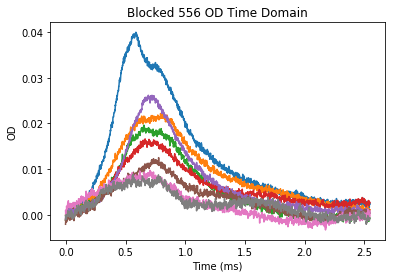

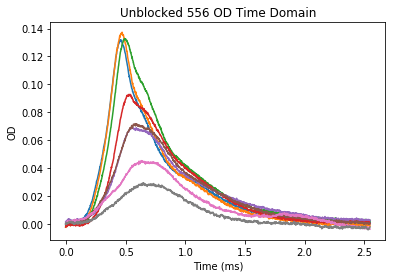

In [67]:
style = {'description_width': 'initial'}

folder_path_w = widgets.Text(
    value='20181205',
    placeholder='This Notebook Directory/...',
    description='Folder path',
    disabled=False,
    style=style
)
start_num_w = widgets.IntText(
    value=28,
    description='Starting File',
    disabled=False,
    style=style
)
stop_num_w = widgets.IntText(
    value=43,
    description='Ending File',
    disabled=False,
    style=style
)
start_setpnt_w = widgets.FloatText(
    value=0.07,
    description='Starting Set Point',
    disabled=False,
    style=style
)
stop_setpnt_w = widgets.FloatText(
    value=-0.13,
    description='Ending Set Point',
    disabled=False,
    style=style
)
setpnt_int_w = widgets.FloatText(
    value=-0.04,
    description='Set Point Step Size',
    disabled=False,
    style=style
)
print_w = widgets.Checkbox(
    value=False,
    description='Print Output?',
    disabled=False
)

go_button = widgets.Button(
    description='Generate Spectra',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

num_data_pnts_w = widgets.FloatText(
    value=7,
    description='Number of data points in spectra',
    disabled=False,
    style=style
)

num_spectra_w = widgets.FloatText(
    value=5,
    description= 'Number of spectra',
    disabled=False,
    style=style
)
lb = LoadedButton(description="Generate Spectra", value=[])
lb.on_click(gen_spectra)
row0=folder_path_w
r0=widgets.HBox([row0])
row1=[start_num_w,stop_num_w]
r1 = widgets.HBox(row1)
# row2=[start_setpnt_w,stop_setpnt_w,setpnt_int_w]
# r2 = widgets.HBox(row2)
# row3=[num_data_pnts_w,num_spectra_w]
# r3=widgets.HBox(row3)
r4 = widgets.HBox([lb,print_w])
widgets.VBox([r0,r1,r4])

In [68]:
all_data2 = lb.value

In [73]:
blocked2=all_data2[0]
unblocked2=all_data2[1]
blocked_time2=all_data2[3]
unblocked_time2=all_data2[2]
avg_time2=all_data2[4]

enhancement2 = [u/b for b,u in zip(blocked2,unblocked2)] 

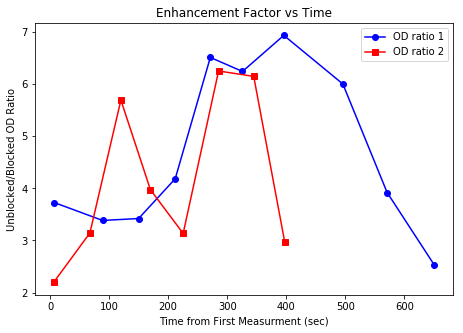

In [71]:
plt.figure(figsize=(7.5,5))
plt.plot(avg_time1,enhancement1,'bo-',label='OD ratio 1')
plt.plot(avg_time2,enhancement2,'rs-',label='OD ratio 2')
plt.title('Enhancement Factor vs Time')
plt.xlabel('Time from First Measurment (sec)')
plt.ylabel('Unblocked/Blocked OD Ratio')
plt.legend(loc='best');

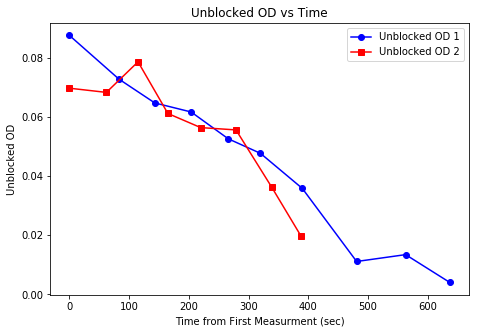

In [75]:
plt.figure(figsize=(7.5,5))
plt.plot(unblocked_time1,unblocked1,'bo-',label='Unblocked OD 1')
plt.plot(unblocked_time2,unblocked2,'rs-',label='Unblocked OD 2')
plt.title('Unblocked OD vs Time')
plt.xlabel('Time from First Measurment (sec)')
plt.ylabel('Unblocked OD')
plt.legend(loc='best');

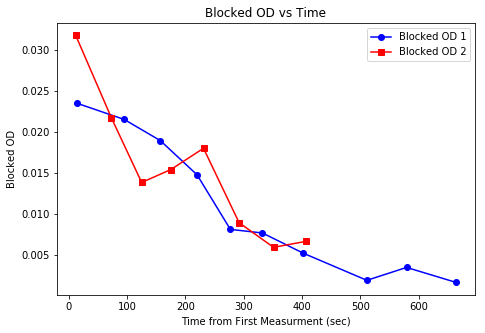

In [76]:
plt.figure(figsize=(7.5,5))
plt.plot(blocked_time1,blocked1,'bo-',label='Blocked OD 1')
plt.plot(blocked_time2,blocked2,'rs-',label='Blocked OD 2')
plt.title('Blocked OD vs Time')
plt.xlabel('Time from First Measurment (sec)')
plt.ylabel('Blocked OD')
plt.legend(loc='best');

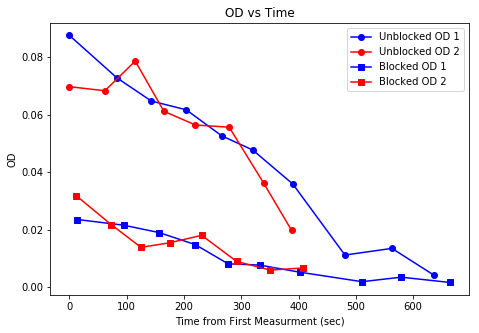

In [77]:
plt.figure(figsize=(7.5,5))
plt.plot(unblocked_time1,unblocked1,'bo-',label='Unblocked OD 1')
plt.plot(unblocked_time2,unblocked2,'ro-',label='Unblocked OD 2')
plt.plot(blocked_time1,blocked1,'bs-',label='Blocked OD 1')
plt.plot(blocked_time2,blocked2,'rs-',label='Blocked OD 2')
plt.title('OD vs Time')
plt.xlabel('Time from First Measurment (sec)')
plt.ylabel('OD')
plt.legend(loc='best');